CIR sample size: 24
Length of missing frame indices: 0


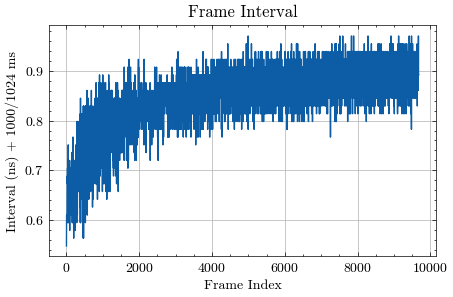

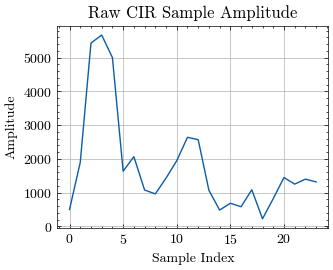

[np.uint32(79), np.uint32(81), np.uint32(80), np.uint32(79), np.uint32(81), np.uint32(95), np.uint32(121), np.uint32(96), np.uint32(104), np.uint32(89)]
STAGE 1: Initial raw amplitude correlation alignment
   Using first frame as reference

STAGE 2: Frame-by-frame correlation with min-max normalization
------------------------------------------------------------
   Raw correlation shifts applied: mean=1.77, std=1.52
   Correlation power range: [7.93e+01, 8.71e+01]

STAGE 3: Outlier detection based on correlation power
------------------------------------------------------------
   Threshold: 5.94e+01
   Found 0 outlier frames based on raw correlation

STAGE 4: Interpolating outlier frames
------------------------------------------------------------
   No outliers to interpolate

STAGE 5: Derivative-based correlation alignment
------------------------------------------------------------
   Using derivative type: 2nd
   Using mean of first 1 frames as reference
   2nd derivative: shift r

In [3]:
from cir_utils import *
from correlation_alignment import *
plt.style.use(['science', 'no-latex'])

# ===== Load CIR processing parameters via Hydra config =====

config = load_cir_config()
# print(OmegaConf.to_yaml(config))

INPUT_FOLDER = config.input_folder
INPUT_FILE = config.input_file

if INPUT_FILE and not os.path.isabs(INPUT_FILE):
    INPUT_FILE = os.path.join(INPUT_FOLDER, INPUT_FILE)
if not INPUT_FILE:
    INPUT_FILE = get_latest_file(os.path.join(INPUT_FOLDER, 'rx'))
if not INPUT_FILE:
    raise FileNotFoundError('No CIR file found using configuration or latest file lookup.')

time_stamp_suffix = os.path.basename(INPUT_FILE).split('cir_data_rx')[-1].split('.')[0]

discard_reading = config.discard_reading
upsample_factor = config.upsample_factor

rx_cir = np.load(INPUT_FILE, allow_pickle=True)[discard_reading:]
CIR_SAMPLE = rx_cir.shape[1]
print('CIR sample size:', CIR_SAMPLE)

diag_file = os.path.join(INPUT_FOLDER, 'diag', f'diag_data_rx{time_stamp_suffix}.npy')
diag_data = np.load(diag_file, allow_pickle=True)[discard_reading:]

frame_idx_list = np.array([diag['D'] for diag in diag_data])
missing_frame_idx = np.where(np.diff(frame_idx_list) % 256 != 1)[0]
print("Length of missing frame indices:", len(missing_frame_idx))
index_fp = np.array([i['index_fp_u32']/64 for i in diag_data], dtype=np.float32)

start_time = diag_data[0]['timestamp']
relative_times = [d['timestamp'] - start_time for d in diag_data]
frame_interval = np.array([i%17207.401027 for i in np.diff(relative_times)])
frame_interval = medfilt(frame_interval[0:], kernel_size=5)
plt.figure(figsize=(5, 3))
plt.plot((frame_interval-1000/1024)*1e6)
plt.title('Frame Interval')
plt.xlabel('Frame Index')
plt.ylabel('Interval (ns) + 1000/1024 ms')
# plt.ylim(1-1e-3,1+1e-3)
plt.grid()
# plt.savefig('frame_interval.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


plt.plot(np.abs(rx_cir[100]))
plt.title('Raw CIR Sample Amplitude')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()
plt.close()

# ===== Upsample the CIR and align the data =====

index_fp = [i['index_fp_u32'] for i in diag_data]
index_fp = np.array(index_fp, dtype=np.uint32)
index_fp = [i/64 - i//64 for i in index_fp]  # Fractional part of the index_fp
shift_64 = np.array([i * upsample_factor for i in index_fp], dtype=np.uint32)  # Shifted index_fp for upsampling

zero_padded_num = config.zero_padded_num
zero_padded_rx_cir = np.zeros((rx_cir.shape[0], rx_cir.shape[1] + zero_padded_num * 2), dtype=complex)
zero_padded_rx_cir[:, zero_padded_num:zero_padded_num+rx_cir.shape[1]] = rx_cir
del rx_cir
rx_cir = zero_padded_rx_cir

# upsample the CIR by 64 using FFT
cir_upsampled = np.zeros((rx_cir.shape[0], rx_cir.shape[1] * upsample_factor), dtype=complex)
for i in range(rx_cir.shape[0]):
    X = np.fft.fft(rx_cir[i], n=rx_cir.shape[1])
    # zero-padding in the frequency domain
    X_upsampled = np.zeros(X.shape[0] * upsample_factor, dtype=complex)
    X_upsampled[:X.shape[0]//2] = X[:X.shape[0]//2]
    X_upsampled[-X.shape[0]//2:] = X[-X.shape[0]//2:]
    cir_upsampled[i] = np.fft.ifft(X_upsampled)[0:cir_upsampled.shape[1]] * upsample_factor

# Shift and normalize
accum_list = [i.get('accumCount', 1) for i in diag_data]
cir_shifted = np.zeros_like(cir_upsampled, dtype=complex)
for i, diag in enumerate(diag_data):
    shift_amount = - int(shift_64[i])  # Positive: move right, Negative: move left   
    shifted = np.roll(cir_upsampled[i], shift_amount)
    accum = accum_list[i]
    if accum == 0:  # avoid divide-by-zero
        exit()
    cir_shifted[i] = shifted / accum
print(accum_list[0:10])
# release memory
del rx_cir, cir_upsampled

# zero-fill the missing index
if len(missing_frame_idx) > 0:
    cir_shifted = insert_zeros_frames(cir_shifted, [i for i in missing_frame_idx])
    print(f"CIR shape after inserting zero frames to {missing_frame_idx}: {cir_shifted.shape}")

# Load alignment parameters from config
los_search_start = int((zero_padded_num + config.los_search_offset_start) * upsample_factor)
los_search_end = int((zero_padded_num + config.los_search_offset_end) * upsample_factor)
peak_win_start = zero_padded_num * upsample_factor
peak_win_end = (zero_padded_num + config.peak_win_offset_end) * upsample_factor

aligned_cir, shifts, combined_outliers = correlation_align_cir(
    cir_data=cir_shifted, 
    los_search_start=los_search_start, 
    los_search_end=los_search_end,
    sg_window=config.savgol_window_length, sg_poly=config.savgol_polyorder,
    corr_factor=0.5,
    derivative_type='2nd',
    raw_corr_threshold=0.7,
    raw_corr_search_window=50,
    interpolate_outliers=True, visualize=False)

aligned_los_part = np.abs(aligned_cir[:, peak_win_start:peak_win_end])
peak_indices = np.argmax(aligned_los_part, axis=1)
los_index = peak_indices.mean() + peak_win_start
print("LOS index:", los_index, "Peak indices:", peak_indices[0:100])

# # Roll LoS index to 100
# los_diff = 3 * upsample_factor - los_index
# cir_aligned = np.roll(aligned_cir, int(np.round(los_diff)), axis=-1)
# los_index += los_diff
cir_aligned = aligned_cir


[7/7] Applying phase correction...


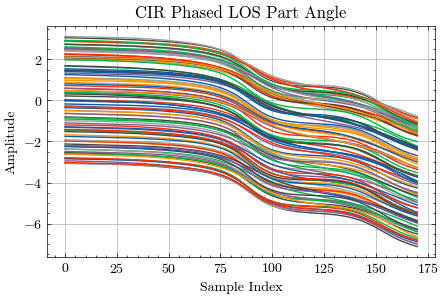

   Phase correction applied


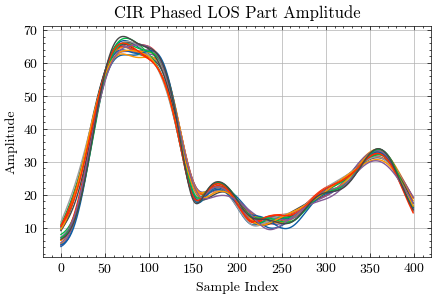

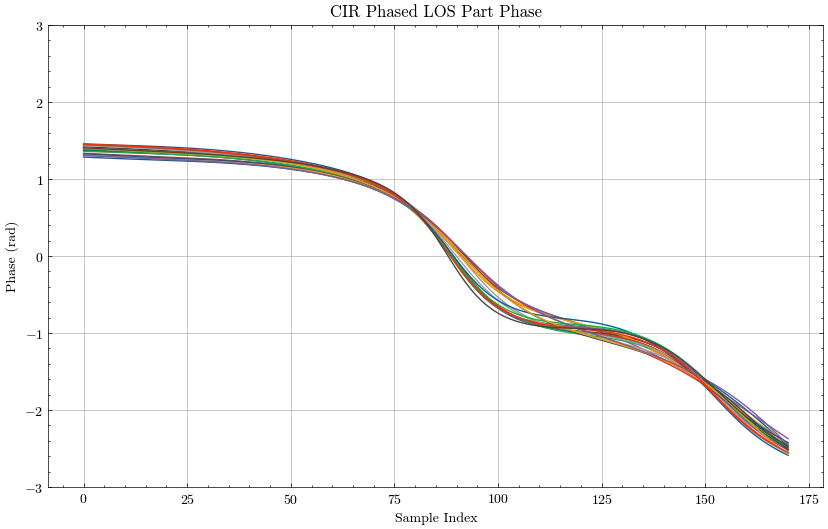

In [4]:
# Zero reference phase
print("\n[7/7] Applying phase correction...")
N, L = cir_aligned.shape
start = int((zero_padded_num + 2) * upsample_factor)
end = int((zero_padded_num + 5) * upsample_factor) + int(los_index)

cir_aligned_los_part = cir_aligned[..., start:end]
cir_aligned_los_part_phase = np.unwrap(np.angle(cir_aligned_los_part), axis=-1)

plt.figure(figsize=(5, 3))
for i in range(0, cir_aligned_los_part_phase.shape[0], 100):
    plt.plot((cir_aligned_los_part_phase[i]))
plt.title('CIR Phased LOS Part Angle')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

ref_phase = cir_aligned_los_part_phase.mean(axis=-1, keepdims=True)
cir_phased = cir_aligned * np.exp(-1j * ref_phase)
print(f"   Phase correction applied")

plt.figure(figsize=(5, 3))
for i in range(0, cir_phased.shape[0], 500):
    plt.plot(np.abs(cir_phased[i, 0:400]))
plt.title('CIR Phased LOS Part Amplitude')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(0, cir_phased.shape[0], 500):
    plt.plot((np.angle(cir_phased[i, start:end])))
plt.ylim(-3, 3)
plt.title('CIR Phased LOS Part Phase')
plt.xlabel('Sample Index')
plt.ylabel('Phase (rad)')
plt.grid()
plt.show()

# for i in range(0, cir_phased.shape[1], upsample_factor):
#     fig, ax = plt.subplots(figsize=(5, 3))
#     x = cir_phased[:, i].real
#     y = cir_phased[:, i].imag
#     ax.plot(x, y, '.')
#     ax.set_title(f'CIR Phased Scatter Plot at Sample {i}')
#     ax.set_xlabel('Real')
#     ax.set_ylabel('Imaginary')
#     ax.grid(True)
#     ax.set_aspect('equal', adjustable='box')
#     # make x/y limits symmetric for a square aspect with some margin
#     m = max(np.max(np.abs(x)), np.max(np.abs(y))) + 1e-12
#     ax.set_xlim(-m, m)
#     ax.set_ylim(-m, m)
#     plt.show()
#     plt.close()

In [5]:
def getCorrelationResults(cir_phased, los_index=los_index, upsample_factor=upsample_factor, pn_code_index=None, starting_idx=None, SHOW_FIG=None):
    config = load_cir_config()

    if pn_code_index is None:
        corr_code = read_packed_kasami_h(config.pn_code)
    else:
        print("")
        print(f"Using PN code index: {pn_code_index}")
        corr_code = read_packed_kasami_h(config.pn_code[pn_code_index])
    
    corr_code = 2 * corr_code - 1  # Convert to bipolar (-1, 1) format
    corr_code = corr_code - np.mean(corr_code)
    seq_len = len(corr_code)

    if starting_idx is None:
        starting_idx = config.starting_idx
    shift_amounts = np.array(config.shift_amount)

    max_corr_list = np.zeros((len(shift_amounts), len(config.corr_indices)), dtype=np.float32)

    for i, shift_amount in enumerate(shift_amounts):
        print(f"\nProcessing with shift amount: {shift_amount}")
        cir_half = cir_phased[shift_amount::2]
        # cir_half = cir_phased[shift_amount::1]
        cir_eval = cir_half[starting_idx:starting_idx+seq_len, :].copy()
        cir_eval_mean = np.mean(cir_eval, axis=0)
        cir_eval -= cir_eval_mean
        assert len(cir_eval) >= len(corr_code), f"Length of cir_eval {len(cir_eval)} does not match length of corr_code {len(corr_code)}"
        if SHOW_FIG is None:
            SHOW_FIG = config.SHOW_FIG
        corr_indices = config.corr_indices

        offset = 0

        tap_variance_list = []
        mean_list = []
        for j, tap in enumerate(corr_indices):
            tap_variance_list.append(np.var(np.abs(cir_eval[:, tap])))
            mean_list.append(np.mean(np.abs(cir_eval[:, tap])))

            corr_power, rho, psr_f = detect_periodic_pn(cir_eval[:, tap], corr_code)
            max_corr_list[i, j] = calculate_pmr(corr_power, config.peak_wnd)

            if SHOW_FIG:
                plt.figure(figsize=(5, 3))
                plt.plot(cir_eval[:, tap].real, cir_eval[:, tap].imag, '.')
                plt.title(f"Constellation for tap {tap} (Excess Path Length: {(tap-los_index-offset)/upsample_factor*30.4589137328:.2f} cm)")
                plt.xlabel('In-Phase')
                plt.ylabel('Quadrature')
                plt.grid()
                plt.show()
                plt.close()
            
                plt.figure(figsize=(5, 3))
                plt.plot(np.abs(cir_eval[100:1000, tap]), '.-')
                plt.title(f"CIR Amplitude for tap {tap} (Excess Path Length: {(tap-los_index-offset)/upsample_factor*30.4589137328:.2f} cm)")
                plt.xlabel('Sample Index')
                plt.ylabel('CIR Amplitude')
                plt.margins(0.1, 0.1)
                plt.grid(True, linestyle='--')
                plt.show()
                plt.close()

                plt.figure(figsize=(5, 3))
                plt.plot(np.angle(cir_eval[100:1000, tap]), '.-')
                plt.title(f"CIR Phase for tap {tap} (Excess Path Length: {(tap-los_index-offset)/upsample_factor*30.4589137328:.2f} cm)")
                plt.xlabel('Sample Index')
                plt.ylabel('CIR Phase (rad)')
                plt.margins(0.1, 0.1)
                plt.grid(True, linestyle='--')
                plt.show()
                plt.close()

                plt.figure(figsize=(5, 3))
                plt.plot(corr_power, '.-')
                plt.title(f"Correlation power for tap {tap} (Excess Path Length: {(tap-los_index-offset)/upsample_factor*30.4589137328:.2f} cm)")
                plt.xlabel('Correlation Tap Index')
                plt.ylabel('Correlation Power')
                plt.margins(0.1, 0.1)
                plt.grid(True, linestyle='--')
                plt.xlim(np.argmax(corr_power)-config.peak_wnd, np.argmax(corr_power)+config.peak_wnd)
                plt.savefig(f"{INPUT_FILE}_tap_{tap}_si{starting_idx}_sa{shift_amount}.png", dpi=300)
                plt.show()
                plt.close()
                print(f"Max correlation for tap {tap}:")
                print(f"for real+imag: {np.max(corr_power):.2f}, max index: {np.argmax(corr_power)}, min index: {np.argmin(corr_power)}")

        # # min-max normalization
        # max_corr_list = (max_corr_list - np.min(max_corr_list)) / (np.max(max_corr_list) - np.min(max_corr_list))
        # max_corr_list -= np.mean(max_corr_list) 
        plt.figure(figsize=(6, 3))
        plt.plot(corr_indices, max_corr_list[i], marker='.', linestyle='-')
        # Set primary x-axis (bottom) for CIR Taps
        plt.xlabel('CIR Taps')

        # Create secondary x-axis (top) for Excess Path Length
        def excess_path_length(indices):
            return (np.array(indices) - los_index - offset) / upsample_factor * 30.4589137328

        ax = plt.gca()
        secax = ax.secondary_xaxis('top', functions=(excess_path_length, 
                                                    lambda x: (x / 30.4589137328) * upsample_factor + los_index + offset))
        secax.set_xlabel('Excess Path Length (cm)')
        plt.grid(True, linestyle='--')
        plt.xlabel('CIR Taps')
        plt.ylabel('Peak-to-Mean Ratio')
        plt.ylim(np.min(max_corr_list[i])*0.8, np.max(max_corr_list[i])*1.1)

        # mark the maximum point
        max_idx = int(np.argmax(max_corr_list[i]))
        plt.plot(corr_indices[max_idx], max_corr_list[i, max_idx], 'rx')  # highlight max point
        # add a text box showing the corresponding excess path length
        excess_length_at_max = excess_path_length(corr_indices[max_idx])
        plt.text(corr_indices[max_idx], max_corr_list[i, max_idx], f'{excess_length_at_max:.2f} cm', 
                verticalalignment='bottom', color='red')

        # plt.savefig(f"{INPUT_FILE}_pmr.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        # Convert np.argmax(max_corr_list) to int for ListConfig indexing
        max_idx = int(np.argmax(max_corr_list[i]))
        print("Max correlation index:", corr_indices[max_idx])
        print("Max correlation value:", np.max(max_corr_list[i]))
        print("Excess Path Length at max correlation:", excess_path_length(corr_indices[max_idx]))
    
    # return the max_corr_list that has larger maximum value
    if np.max(max_corr_list[0]) >= np.max(max_corr_list[1]):
        return max_corr_list[0], corr_indices
    else:
        return max_corr_list[1], corr_indices
# print(los_index)
# max_corr, corr_indices = getCorrelationResults(cir_phased, starting_idx=5000, pn_code_index=1)
# max_corr, corr_indices = getCorrelationResults(cir_phased, starting_idx=7000, pn_code_index=2)
# max_corr, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=3)
# max_corr, corr_indices = getCorrelationResults(cir_phased, starting_idx=3000, pn_code_index=4)


Using PN code index: 0

Processing with shift amount: 0


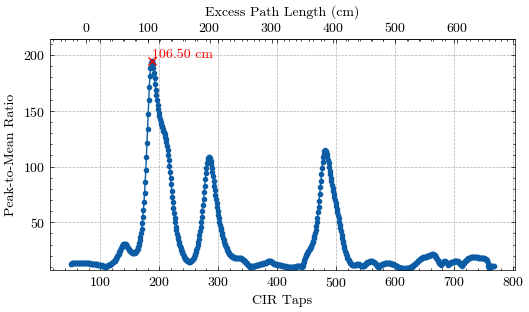

Max correlation index: 187
Max correlation value: 194.57048
Excess Path Length at max correlation: 106.5031368575731

Processing with shift amount: 1


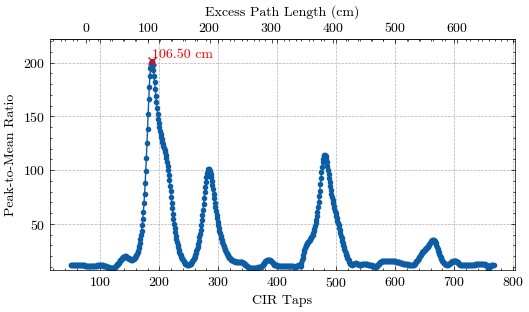

Max correlation index: 187
Max correlation value: 201.4872
Excess Path Length at max correlation: 106.5031368575731

Using PN code index: 1

Processing with shift amount: 0


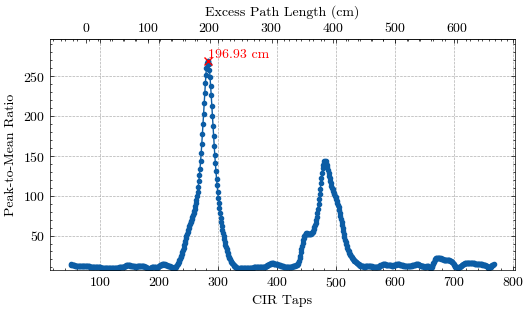

Max correlation index: 282
Max correlation value: 269.23572
Excess Path Length at max correlation: 196.9280370018231

Processing with shift amount: 1


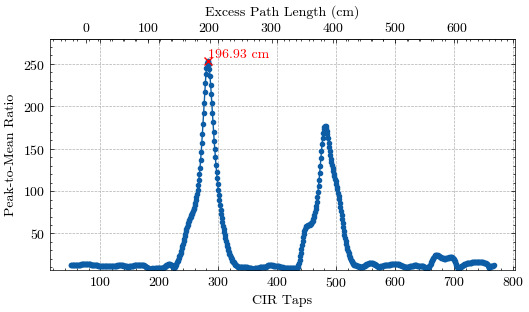

Max correlation index: 282
Max correlation value: 253.44183
Excess Path Length at max correlation: 196.9280370018231

Using PN code index: 2

Processing with shift amount: 0


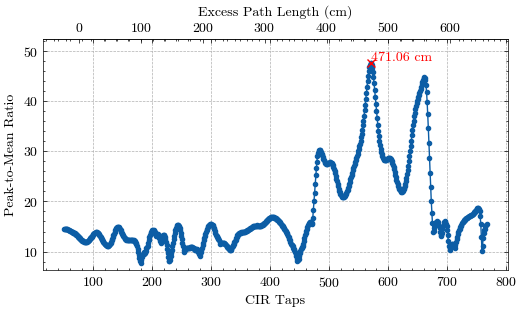

Max correlation index: 570
Max correlation value: 47.486984
Excess Path Length at max correlation: 471.0582605970231

Processing with shift amount: 1


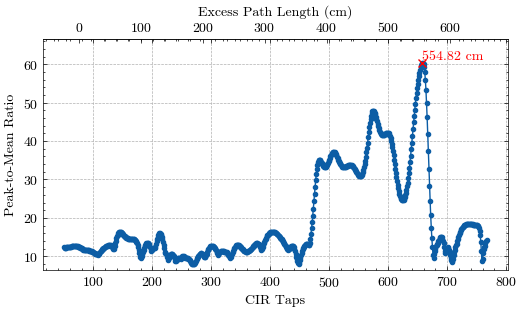

Max correlation index: 658
Max correlation value: 60.438953
Excess Path Length at max correlation: 554.820273362223

Using PN code index: 3

Processing with shift amount: 0


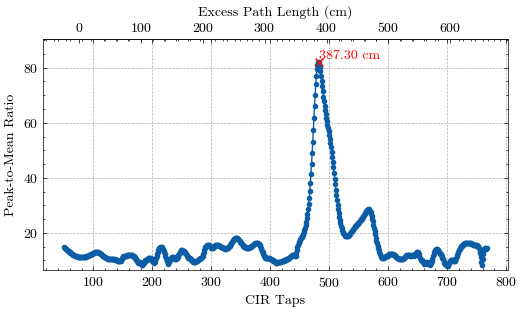

Max correlation index: 482
Max correlation value: 82.056244
Excess Path Length at max correlation: 387.2962478318231

Processing with shift amount: 1


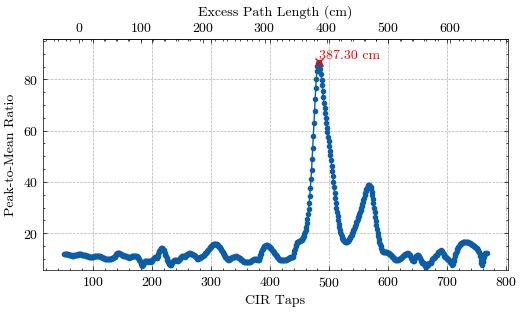

Max correlation index: 482
Max correlation value: 86.8675
Excess Path Length at max correlation: 387.2962478318231

Using PN code index: 4

Processing with shift amount: 0


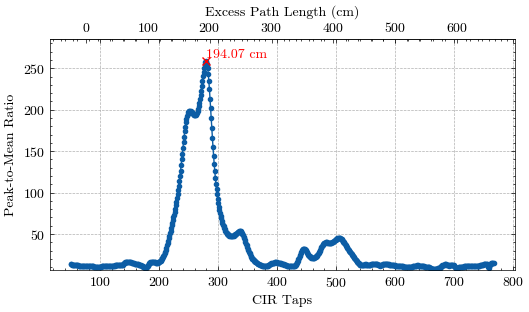

Max correlation index: 279
Max correlation value: 258.93982
Excess Path Length at max correlation: 194.0725138393731

Processing with shift amount: 1


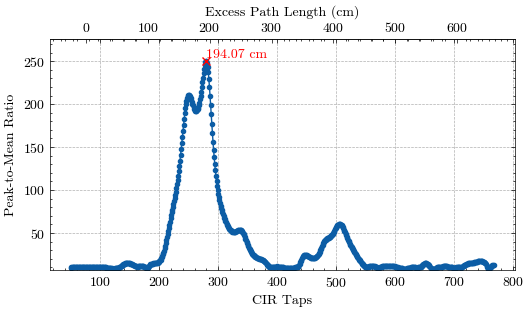

Max correlation index: 279
Max correlation value: 250.17699
Excess Path Length at max correlation: 194.0725138393731


In [7]:
max_corr_0, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=0)
max_corr_1, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=1)
max_corr_2, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=2)
max_corr_3, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=3)
max_corr_4, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=4)

five_tag_corr = np.array([max_corr_0, max_corr_1, max_corr_2, max_corr_3, max_corr_4])

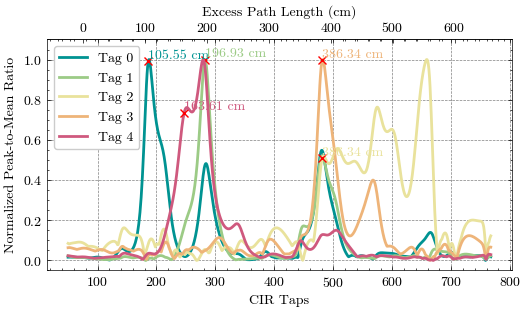

In [8]:
from palettable.cartocolors.diverging import Temps_5
colors = Temps_5.mpl_colors
plt.style.use(['science', 'grid', 'no-latex', 'high-contrast'])

# Create secondary x-axis (top) for Excess Path Length
def excess_path_length(indices):
    return (np.array(indices) - los_index - 0) / upsample_factor * 30.4589137328

from scipy.signal import savgol_filter, argrelextrema

def get_first_large_peak_sg(
    signal: np.ndarray, 
    amp_threshold: float = 0.3,
    d1_threshold: float = 1.0, 
    d2_threshold: float = 0.5,
    window_length: int = 11, 
    polyorder: int = 3
) -> int:
    """
    Identifies the index of the first large peak using SG filtering and derivative thresholds.
    
    Args:
        signal (np.ndarray): 1D input array.
        amp_threshold (float): Min normalized amplitude (0-1) to return a peak (default 0.3).
        d1_threshold (float): MAX slope (abs value) allowed for a merged peak/shoulder.
                              Controls 'flatness' required to be a shoulder.
        d2_threshold (float): MIN curvature (abs value) required for any peak.
                              Controls 'sharpness' required to be a peak.
        window_length (int): Length of the filter window (must be odd).
        polyorder (int): Order of the polynomial used to fit the samples.

    Returns:
        int: Index of the first large peak, or -1 if none found.
    """
    y = np.array(signal, dtype=float)
    
    # Check for valid window length (must be odd and <= signal length)
    if window_length >= len(y):
        window_length = len(y) - 1 if (len(y) % 2 == 0) else len(y)
    if window_length % 2 == 0:
        window_length += 1
        
    # --- 1. Compute Smoothed Derivatives via SG Filter ---
    # deriv=0 gives smoothed signal, deriv=1 gives 1st derivative, etc.
    # We use a slight delta=1.0 assumption for indices
    y_smooth = savgol_filter(y, window_length, polyorder, deriv=0)
    dy = savgol_filter(y, window_length, polyorder, deriv=1)
    d2y = savgol_filter(y, window_length, polyorder, deriv=2)

    candidates = set()

    # --- 2. Identify Standard Peaks (Zero-Crossing of 1st Deriv) ---
    # Find where dy crosses from positive to negative
    # We look for indices where dy[i] > 0 and dy[i+1] < 0
    # and confirm it corresponds to a negative curvature (d2y < 0)
    zero_crossings = np.where(np.diff(np.signbit(dy)))[0]
    
    for idx in zero_crossings:
        # Check if it's a peak (slope goes + to -) and meets sharpness threshold
        # We check d2y at the crossing point
        if dy[idx] > 0 and dy[idx+1] < 0:
             if d2y[idx] < -d2_threshold:
                 candidates.add(idx)

    # --- 3. Identify Merged/Shoulder Peaks (Minima of 2nd Deriv) ---
    # Shoulders don't cross zero in dy, but have strong negative curvature
    d2y_minima = argrelextrema(d2y, np.less)[0]
    
    for idx in d2y_minima:
        # 1. Sharpness Check: Must have strong negative curvature
        curvature_pass = d2y[idx] < -d2_threshold
        
        # 2. Flatness Check: Slope must be low enough to be "shoulder-like"
        # If slope is massive, it's likely just an inflection point on a wall, not a peak
        slope_pass = abs(dy[idx]) < d1_threshold
        
        if curvature_pass and slope_pass:
            candidates.add(idx)

    if not candidates:
        return -1

    sorted_candidates = sorted(list(candidates))

    # --- 4. Normalization ---
    s_min = np.min(y_smooth)
    s_max = np.max(y_smooth)
    
    if s_max - s_min == 0:
        return -1
        
    # Use the SMOOTHED signal for amplitude check to avoid noise spiking it
    y_norm = (y_smooth - s_min) / (s_max - s_min)

    # --- 5. Selection ---
    for idx in sorted_candidates:
        if y_norm[idx] > amp_threshold:
            return idx

    return -1

min_max_norm = True

plt.figure(figsize=(6, 3))
for i, max_corr in enumerate(five_tag_corr):
    if min_max_norm:
        max_corr = (max_corr - np.min(max_corr)) / (np.max(max_corr) - np.min(max_corr))
    plt.plot(corr_indices, max_corr, linestyle='-', label=f'Tag {i}', color=colors[i], linewidth=2)
    # mark the maximum point
    max_idx = int(np.argmax(max_corr))
    first_path = int(get_first_large_peak_sg(max_corr, amp_threshold=0.3, d1_threshold=10.0, d2_threshold=-5,
                                            window_length=21, polyorder=3))
    # plt.plot(corr_indices[max_idx], max_corr[max_idx], 'rx')  # highlight max point
    plt.plot(corr_indices[first_path], max_corr[first_path], 'rx')  # highlight first large peak
    # add a text box showing the corresponding excess path length
    # excess_length_at_max = excess_path_length(corr_indices[max_idx])
    # plt.text(corr_indices[max_idx], max_corr[max_idx], f'{excess_length_at_max:.2f} cm', 
    #         verticalalignment='bottom', color='red')
    excess_length_at_first = excess_path_length(corr_indices[first_path])
    plt.text(corr_indices[first_path], max_corr[first_path], f'{excess_length_at_first:.2f} cm', 
            verticalalignment='bottom', color=colors[i])
# Set primary x-axis (bottom) for CIR Taps
plt.xlabel('CIR Taps')
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(excess_path_length, 
                                            lambda x: (x / 30.4589137328) * upsample_factor + los_index + 0))
secax.set_xlabel('Excess Path Length (cm)')
plt.grid(True, linestyle='--')
plt.legend()
plt.xlabel('CIR Taps')
if min_max_norm:
    plt.ylabel('Normalized Peak-to-Mean Ratio')
    plt.ylim(-0.05, 1.1)
else:
    plt.ylim(np.min(five_tag_corr)*0.8, np.max(five_tag_corr)*1.1)
    plt.ylabel('Peak-to-Mean Ratio')
# plt.savefig(f"{INPUT_FILE}_fivetag_pmr.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

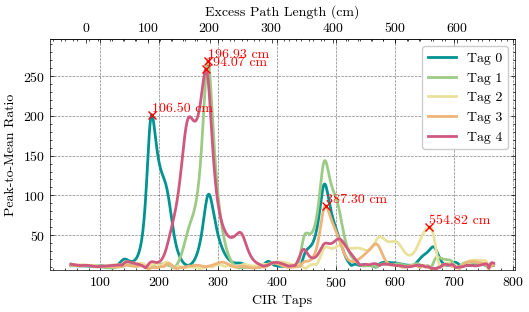

In [9]:
from palettable.cartocolors.diverging import Temps_5
colors = Temps_5.mpl_colors
plt.style.use(['science', 'grid', 'no-latex', 'high-contrast'])

# Create secondary x-axis (top) for Excess Path Length
def excess_path_length(indices):
    return (np.array(indices) - los_index - 0) / upsample_factor * 30.4589137328

plt.figure(figsize=(6, 3))
for i, max_corr in enumerate(five_tag_corr):
    # max_corr = (max_corr - np.min(max_corr)) / (np.max(max_corr) - np.min(max_corr))
    plt.plot(corr_indices, max_corr, linestyle='-', label=f'Tag {i}', color=colors[i], linewidth=2)
    # mark the maximum point
    max_idx = int(np.argmax(max_corr))
    plt.plot(corr_indices[max_idx], max_corr[max_idx], 'rx')  # highlight max point
    # add a text box showing the corresponding excess path length
    excess_length_at_max = excess_path_length(corr_indices[max_idx])
    plt.text(corr_indices[max_idx], max_corr[max_idx], f'{excess_length_at_max:.2f} cm', 
            verticalalignment='bottom', color='red')
# Set primary x-axis (bottom) for CIR Taps
plt.xlabel('CIR Taps')
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(excess_path_length, 
                                            lambda x: (x / 30.4589137328) * upsample_factor + los_index + 0))
secax.set_xlabel('Excess Path Length (cm)')
plt.grid(True, linestyle='--')
plt.legend()
plt.xlabel('CIR Taps')
plt.ylabel('Peak-to-Mean Ratio')
plt.ylim(np.min(five_tag_corr)*0.8, np.max(five_tag_corr)*1.1)
# plt.ylim(-0.05, 1.1)
plt.savefig(f"{INPUT_FILE}_fivetag_pmr.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()